# 打开股票量化的黑箱(自己动手实现一个印钞机) 第六章
### 作者：阿布🐶

### 未经本人允许禁止转载

##  `非均衡胜负收益`带来的必然`非均衡胜负比例`，目标由`因子`的能力解决一部分，`模式识别`提升关键的一部分

上一章使用gmm-hmm统计分析分类，进行模式识别，大体思路已经说明，这一章开始，具体完善这个方法，提高胜率
这一章将引入裁判机制，主裁与辅助裁判

In [1]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
from UmpMain import UmpMainClass
from UmpJump import UmpJumpClass
from MlFiterJumpPd import MlFiterJumpPdClass

依然是从加载数据开始

In [4]:
fn = ZEnv.g_project_root + '/data/cache/golden_n6_test_abu'
key = 'golden_n6_test_abu'
orders_pd_test = ZCommonUtil.load_hdf5(fn, key)
orders_pd_test.shape

(4837, 31)

In [5]:
fn =  ZEnv.g_project_root + '/data/cache/golden_n6_train_abu'
key = 'golden_n6_train_abu'
orders_pd_train = ZCommonUtil.load_hdf5(fn, key)
orders_pd_train.shape

(42538, 31)

和之前不一样的地方，使用全量测试集数据，没有分割测试集与训练集的数据为的是之后构建主裁将使用这份全量的数据作为训练集，不再切割的目的是担心gmm－hmm只是识别了这段时间内的特征，对同一时段内的不同股票交易可以生效，但是实盘就不管用了，这样的话，我们不切割数据，训练完整个模型之后再向前回溯一整年的数据作为测试数据集

In [7]:
fn = ZEnv.g_project_root + '/data/cache/orders_pd_ump_hit_predict_abu'
key = 'orders_pd_ump_hit_predict_abu'
orders_pd_ump = ZCommonUtil.load_hdf5(fn, key)
orders_pd_ump.shape

(47374, 39)

上一章只用到了UmpMainClass 也就是**主裁**
引入辅助裁判概念，这里的实例就是跳空裁判

对跳空的概念，请自行搜索，我这里用的实例基本上都是股票领域里非常常用的理念，
对这里的跳空实现感兴趣的请参考文章的第一章关于跳空的示例，也可查看源代码TLineJump

**jump ump 辅助裁决**

In [9]:
# 只针对有21天内有跳空行为的交易，一下子就只剩下5035了，只简单跳空强度和跳空间隔天数两个特征组成
ump_jump = UmpJumpClass(orders_pd_ump, MlFiterJumpPdClass, dd_threshold=21)
ZLog.info(ump_jump.fiter.df.shape)
ump_jump.fiter.df.head()

(5035, 3)


,result,jump_power,diff_days
2015-07-28,1,-1.382554,6
2015-07-28,0,-1.084962,21
2015-07-28,0,-3.415892,5
2015-07-28,0,-3.236708,4
2015-07-28,0,-1.307611,13


all fit order = (44906, 39)
win rate = 0.500757137131
profit_cg.sum() = 272.117613217
win mean = 0.0743788075658 loss_mean = -0.0626291433739 


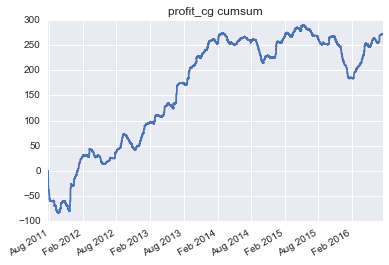

all fit order = (5035, 39)
win rate = 0.498907646475
profit_cg.sum() = 20.2331512267
win mean = 0.0673137719871 loss_mean = -0.0591414557032 


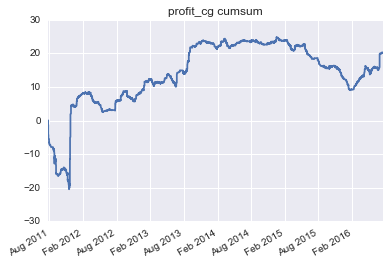

In [12]:
# 这个你应该熟悉了，看看这些数据的交易大体情况，第一个不过滤数据，即所有传进去的4w多条交易
ump_jump.show_general()
# 过滤数据，只统计符合条件的数据，即那5千多条的情况
ump_jump.show_general(use_fiter=True)

**从上面可以发现跳空监控区，收益小于整个区间**

死心不改的仍然使用svm对模型想要抽取特征，结果🙈

In [13]:
ump_jump.fiter().estimator.svc()
ump_jump.fiter().train_test_split_xy()

(5035, 2)
(4531, 2)
(504, 2)
accuracy = 0.56
precision_score = 0.57
recall_score = 0.54
             precision    recall  f1-score   support

        0.0       0.55      0.59      0.57       247
        1.0       0.57      0.54      0.56       257

avg / total       0.56      0.56      0.56       504



Confusion Matrix  [[145 102]
 [119 138]]
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 145 | 102 |
Actual   |-----|-----|
       1 | 119 | 138 |
         |-----|-----|


### 下面继续使用gmm-hmm方式进行特征抽取, 由于数据不多，从18个分类到42个分类，阀值还是选择65%

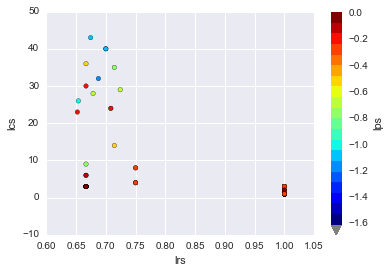

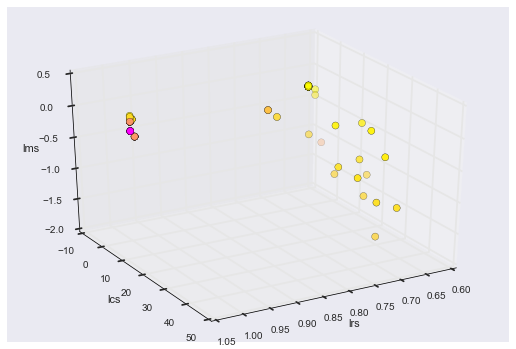

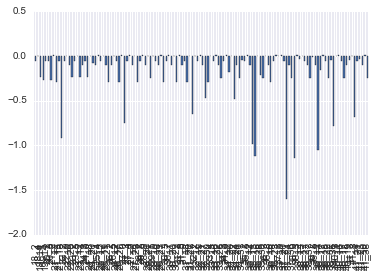

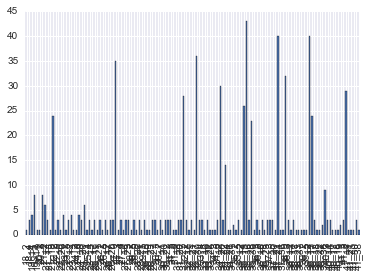

,lcs,lrs,lps,lms
18_2,1.0,1.000000,-0.059441,-0.059441
18_4,3.0,0.666667,-0.003412,-0.001137
18_14,4.0,0.750000,-0.233595,-0.058399
19_5,8.0,0.750000,-0.265865,-0.033233
19_14,1.0,1.000000,-0.059441,-0.059441
20_2,1.0,1.000000,-0.059441,-0.059441
20_8,8.0,0.750000,-0.265865,-0.033233
21_2,6.0,0.666667,0.011840,0.001973
21_12,3.0,1.000000,-0.294978,-0.098326
21_13,1.0,1.000000,-0.059441,-0.059441


In [15]:
ump_jump.gmm_component_filter(p_ncs=np.arange(18, 42), threshold=0.65)

如下所示找个数量和失败率都很高的分类看看
发现特征了吗？跳空缺口的能量大概在－1.6左右，跳空时间间隔大约是9-11
这个类别里因子触发的70%交易都以失败告终，所以呢？拦截呗！（拦截这个词对我有种特殊的情怀，那段美好的青春岁月好怀念！👻）

In [16]:
ump_jump.nts['21_18']

,result,jump_power,diff_days,ind,ss,profit
2015-08-19,0,-1.633778,11,50,18,-0.036806
2015-09-28,1,-1.618578,11,119,18,0.007078
2016-01-19,0,-1.664892,9,398,18,-0.025568
2014-08-11,1,-1.588977,10,923,18,0.086466
2015-02-02,0,-1.660151,9,1241,18,-0.032483
2015-05-22,0,-1.620002,9,1511,18,-0.024310
2015-06-08,0,-1.642379,9,1558,18,-0.021877
2015-06-25,0,-1.699512,9,1586,18,-0.025143
2013-08-16,1,-1.680736,9,1698,18,0.061564
2013-10-01,1,-1.656696,10,1850,18,0.047325


下面统计一下跳空能量的分布情况，进一步总结特征

NormaltestResult(statistic=11612.386867948926, pvalue=0.0)


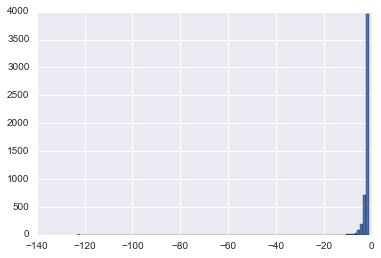

jump_power show hist and qcuts
(-1.0692, -1.000217]    504
(-1.243, -1.149]        504
(-1.669, -1.499]        504
(-2.304, -1.932]        504
[-123.0916, -3.0491]    504
(-1.149, -1.0692]       503
(-1.366, -1.243]        503
(-1.499, -1.366]        503
(-1.932, -1.669]        503
(-3.0491, -2.304]       503
Name: jump_power, dtype: int64


In [17]:
import scipy.stats as scs
import MlFiterBinsCs
ZLog.info(scs.normaltest(ump_jump.fiter.df.jump_power))
MlFiterBinsCs.show_orders_hist(ump_jump.fiter.df, s_list = ['jump_power'])

**如下jump power选取llps没有执行最优化求解，因为数据量太少，按照分类数目要求大于20, 其它0， 0， 0.65来跑跑看看先**

In [19]:
llps = ump_jump.cprs[(ump_jump.cprs['lps'] <= 0) & (ump_jump.cprs['lms'] <= 0 ) 
                & (ump_jump.cprs['lrs'] >=0.65) & (  (ump_jump.cprs['lcs'] >= 20)
                                                    | (ump_jump.cprs['lrs'] == 1) )]
llps

,lcs,lrs,lps,lms
18_2,1.0,1.000000,-0.059441,-0.059441
19_14,1.0,1.000000,-0.059441,-0.059441
20_2,1.0,1.000000,-0.059441,-0.059441
21_12,3.0,1.000000,-0.294978,-0.098326
21_13,1.0,1.000000,-0.059441,-0.059441
21_18,24.0,0.708333,-0.921051,-0.038377
22_2,1.0,1.000000,-0.059441,-0.059441
22_10,1.0,1.000000,-0.101029,-0.101029
23_2,1.0,1.000000,-0.059441,-0.059441
23_13,1.0,1.000000,-0.101029,-0.101029


我擦，预测能提高0.013

nts_pd.shape = (182, 6)
nts_pd loss rate = 0.681318681319
improved rate = 0.0131082423039
predict win rate = 0.512015888779


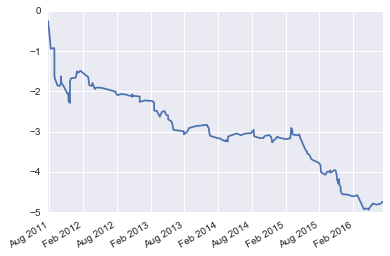

In [20]:
ump_jump.choose_cprs_component(llps)

本地序列化

In [ ]:
ump_jump.dump_clf(llps)

_____

好了，准备进入正题，做好准备，前方高能

### 只有一个主裁是不够的，我们需要构造多个主裁，多个辅助裁判，还有边裁（边裁下一章介绍）

deg ump 主裁，只使用全局最优llps

In [37]:
from MlFiterDegPd import MlFiterDegPdClass
ump_deg = UmpMainClass(orders_pd_ump, MlFiterDegPdClass)
ump_deg.fiter.df.head(2)

,result,deg_hisWindowPd,deg_windowPd,deg_60WindowPd
2015-07-28,1,-1.256691,3.895622,5.363046
2015-07-28,0,15.908454,4.108007,4.199374


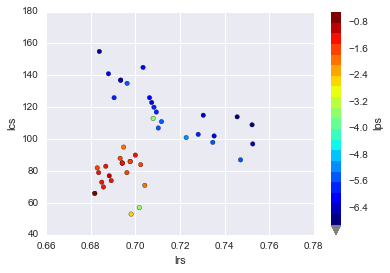

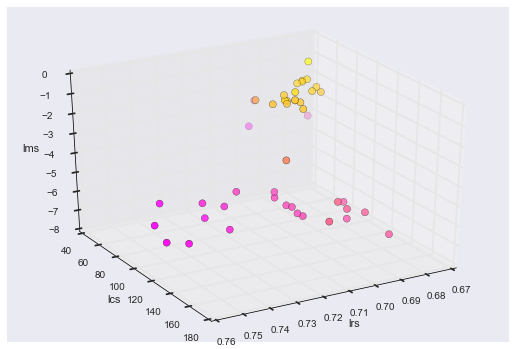

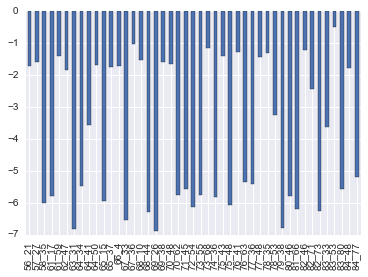

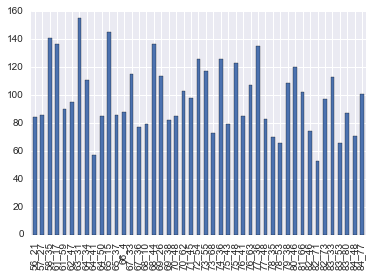

,lcs,lrs,lps,lms
56_21,84.0,0.702381,-1.699820,-0.020236
57_27,86.0,0.697674,-1.591000,-0.018500
58_35,141.0,0.687943,-5.994469,-0.042514
61_17,137.0,0.693431,-5.788397,-0.042251
61_59,90.0,0.700000,-1.401181,-0.015569
62_47,95.0,0.694737,-1.830953,-0.019273
63_31,155.0,0.683871,-6.826563,-0.044042
64_34,111.0,0.711712,-5.487420,-0.049436
64_41,57.0,0.701754,-3.558004,-0.062421
64_50,85.0,0.694118,-1.677678,-0.019737


In [23]:
ump_deg.gmm_component_filter(p_ncs=np.arange(18, 85), threshold=0.68)

nts_pd.shape = (513, 7)
nts_pd loss rate = 0.690058479532
improved rate = 0.00434240413308
predict win rate = 0.505099541264


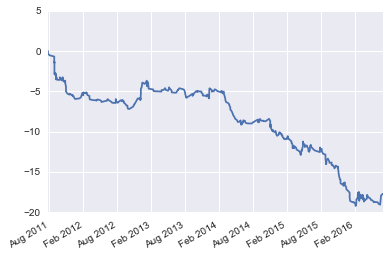

In [25]:
# 只使用全局凸优化寻找最优
brust_min = ump_deg.brust_min()
llps = ump_deg.cprs[(ump_deg.cprs['lps'] <= brust_min[0]) & (ump_deg.cprs['lms'] <= brust_min[1] ) & 
                    (ump_deg.cprs['lrs'] >= brust_min[2])]
ump_deg.choose_cprs_component(llps)
ump_deg.dump_clf(llps)

___

wave ump第二主裁

In [39]:
from MlFiterWavePd import MlFiterWavePdClass
ump_wave = UmpMainClass(orders_pd_ump, MlFiterWavePdClass)
ump_wave.fiter.df.head(2)

,result,wave_score1,wave_score2,wave_score3
2015-07-28,1,0.116619,-0.122372,-0.222840
2015-07-28,0,0.646118,0.731843,0.662114


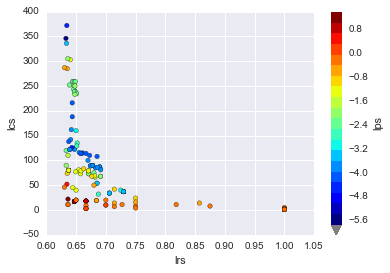

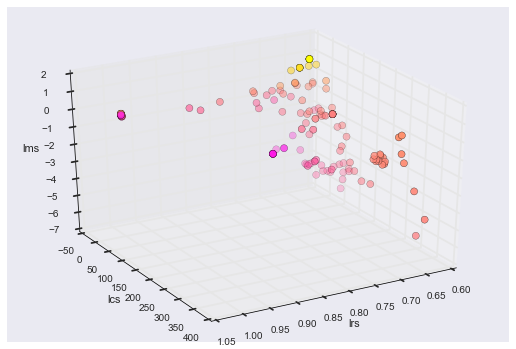

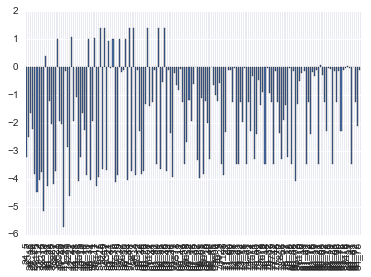

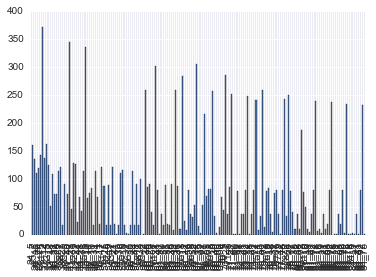

,lcs,lrs,lps,lms
24_5,160.0,0.650000,-3.223928,-0.020150
25_7,135.0,0.651852,-2.515814,-0.018636
26_15,110.0,0.636364,-1.624467,-0.014768
27_26,120.0,0.633333,-2.197939,-0.018316
28_24,142.0,0.640845,-3.833662,-0.026998
31_5,372.0,0.634409,-4.477736,-0.012037
31_12,138.0,0.637681,-4.040783,-0.029281
32_14,162.0,0.641975,-3.757361,-0.023194
33_5,124.0,0.645161,-5.155671,-0.041578
33_18,52.0,0.634615,0.401146,0.007714


In [26]:
ump_wave.gmm_component_filter(p_ncs=np.arange(18, 85), threshold=0.63)

nts_pd.shape = (1126, 7)
nts_pd loss rate = 0.639431616341
improved rate = 0.00699238409121
predict win rate = 0.507749521222


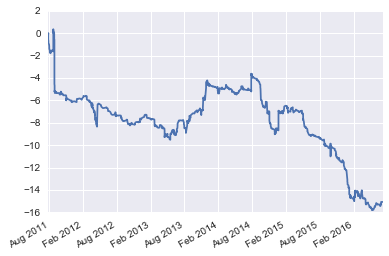

In [27]:
brust_min = ump_wave.brust_min()
llps = ump_wave.cprs[(ump_wave.cprs['lps'] <= brust_min[0]) & (ump_wave.cprs['lms'] <= brust_min[1] ) & 
                    (ump_wave.cprs['lrs'] >= brust_min[2])]
ump_wave.choose_cprs_component(llps)
ump_wave.dump_clf(llps)

____

第三主裁 ump_main

In [42]:
# 构造方式换汤不换药，可以继续封装优化
from MlFiterMainPd import MlFiterMainPdClass
ump_main = UmpMainClass(orders_pd_ump, MlFiterMainPdClass)
ump_main.fiter.df.head(2)

,result,atr_std,deg_60WindowPd,wave_score1
2015-07-28,1,0.045208,5.363046,0.116619
2015-07-28,0,0.234763,4.199374,0.646118


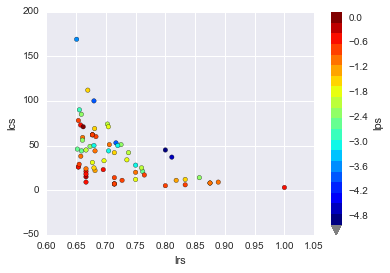

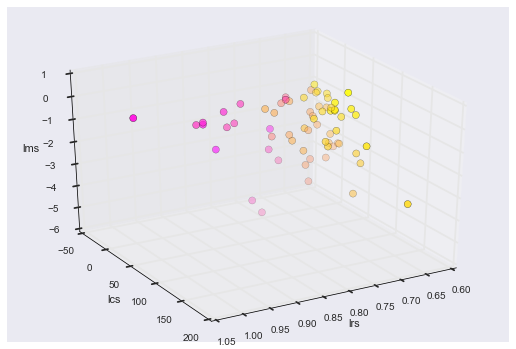

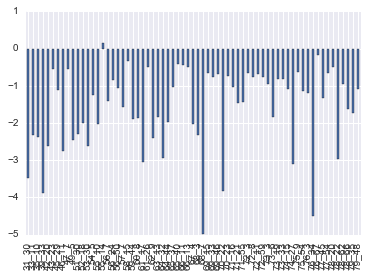

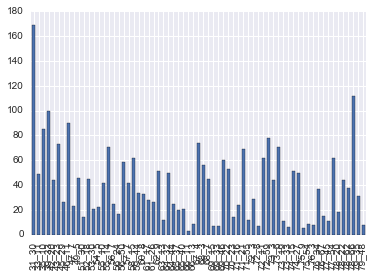

,lcs,lrs,lps,lms
31_30,169.0,0.650888,-3.488626,-0.020643
33_11,49.0,0.673469,-2.314873,-0.047242
35_10,85.0,0.658824,-2.364326,-0.027816
39_33,100.0,0.680000,-3.877226,-0.038772
42_20,44.0,0.659091,-2.604120,-0.059185
43_23,73.0,0.657534,-0.548995,-0.007520
45_29,26.0,0.653846,-1.105545,-0.042521
46_11,90.0,0.655556,-2.752587,-0.030584
47_7,23.0,0.695652,-0.536203,-0.023313
49_5,46.0,0.652174,-2.461245,-0.053505


In [28]:
ump_main.gmm_component_filter(p_ncs=np.arange(18, 80), threshold=0.65)

nts_pd.shape = (804, 7)
nts_pd loss rate = 0.661691542289
improved rate = 0.00578987217744
predict win rate = 0.506547009308


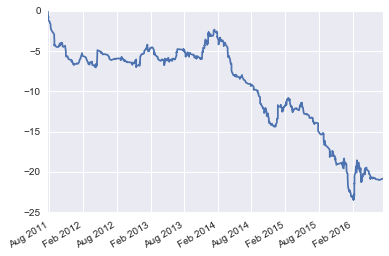

In [29]:
brust_min = ump_main.brust_min()
llps = ump_main.cprs[(ump_main.cprs['lps'] <= brust_min[0]) & (ump_main.cprs['lms'] <= brust_min[1] ) & 
                    (ump_main.cprs['lrs'] >= brust_min[2])]
ump_main.choose_cprs_component(llps)
ump_main.dump_clf(llps)

所有主裁构建完成

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)